In [1]:
import os
from pathlib import Path
os.chdir("/Users/oliverdaniels-koch/projects/elk-experiments")
out_dir = Path("output")
device = "mps"

In [2]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [3]:
from torch import mps
def cur_allocated_memory():
    allocated = mps.current_allocated_memory()
    print(f"Currently allocated: {allocated / 1024**2:.2f} MB")

# Edge Attribution Patching Detector

In [4]:
import os
from functools import partial
from pathlib import Path
import torch
from cupbearer import tasks, detectors, scripts, utils
from cupbearer.detectors import ActivationCache
from cupbearer.detectors.statistical import MahalanobisDetector
from elk_experiments.utils import train_detector_cache
from elk_experiments.tiny_natural_mechanisms_utils import get_task_subset
from elk_experiments.eap_detector import EAPDetector, layer_edge_filter

## Load Task

In [5]:
task = tasks.tiny_natural_mechanisms("hex", device, "pythia-70m")

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer
Moving model to device:  mps


In [6]:
small_task = get_task_subset(task, 2048, 1024, 1024)

## Edge Attribution Detector

In [7]:
from eap.eap_wrapper import EAP

In [8]:
# TODO: look back at edge attribution example
task.model.set_use_split_qkv_input(True)
task.model.set_use_attn_result(True)
task.model.set_use_hook_mlp_in(True)

In [9]:
# use mean probability over effect tokens as metric 
def effect_prob_func(logits, effect_tokens):
    assert logits.ndim == 3
    # Sum over vocab and batch dim (for now we're just computing attribution values, we'll deal with per data instance later)
    probs = logits[:, -1, :].softmax(dim=-1)
    out = probs[:, effect_tokens].mean(dim=-1).mean() # mean over effect tokens, mean over batch
    # out = logits[:, -1, effect_tokens].mean()
    return out

In [10]:
from cupbearer.tasks.tiny_natural_mechanisms import get_effect_tokens
effect_tokens = get_effect_tokens("hex", task.model)

In [11]:
from cupbearer.detectors import ActivationCache

In [12]:
small_task = get_task_subset(task, 2048, 1024, 1024)

In [13]:
detector_dir = out_dir / "pythia-70m-hex-filtered-eap-detector-small"

In [14]:
#TODO: fix cache bug
# eap_cache_path = Path(detector_dir / "activation_cache").with_suffix(utils.SUFFIX)
# if os.path.exists(eap_cache_path):
#     eap_cache = ActivationCache.load(eap_cache_path, device=device)
# else:
eap_cache = ActivationCache(device=device)


In [15]:
class EAPMahalanobisDetector(EAPDetector, MahalanobisDetector):
    pass

In [18]:
eap_detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head"],
    downstream_nodes=["head"],
    edge_filter=partial(layer_edge_filter, excluded_layers={0, 5}),
    seq_len=16,
    layer_aggregation="mean", 
    cache=eap_cache
)

In [17]:
eap_detector.load_weights(detector_dir / "detector.pth")

2024-07-01 16:36:34.048 | INFO     | cupbearer.detectors.anomaly_detector:load_weights:261 - Loading detector from output/pythia-70m-hex-filtered-eap-detector-small/detector.pth


/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-07-01 16:36:49.657 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
eap_scores: torch.Size([1920])
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-01 16:40:51.391 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.6262
2024-07-01 16:40:51.394 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.6084


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.6261787414550781,
               'AP': 0.6084264464145313}}),
 {'all': <Figure size 640x480 with 1 Axes>})

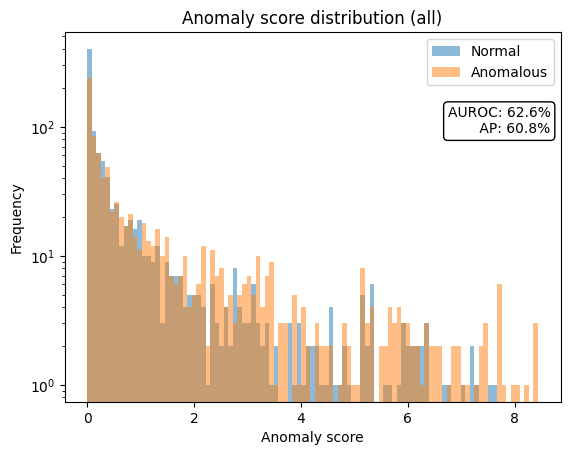

In [19]:
train_detector_cache(
    detector_dir, eap_detector, small_task, batch_size=64, eval_batch_size=64, cache=eap_cache, 
    cache_path=None, overwrite=True, overwrite_cache=True
)

In [ ]:
# reasons why covariance matrix would be bad
# say you had two primary mechanisms for next token alphanumeric 
# 1. uses atten0.0 -> atten2.1 
# 2 uses atten0.5 -> atten2.1

# the covariance of 

In [ ]:
# first should try to filter out un-used

In [ ]:
eap_detector.set_model(task.model)

In [ ]:
def node_layer(node):
    return int(node.split(".")[1])

In [ ]:
node_layer("head.0.0")

In [ ]:
eap_scores = torch.zeros(eap_detector.graph.n_upstream_nodes, eap_detector.graph.n_downstream_nodes)

In [ ]:
eap_detector.graph.top

In [ ]:
# get matrix of tuples of upstream and downstream node names
edge_names = []
for upstream_node_name in eap_detector.graph.upstream_nodes:
    edge_names.append([(upstream_node_name, downstream_node_name) for downstream_node_name in eap_detector.graph.downstream_nodes])

In [ ]:
import numpy as np

In [ ]:
torch.tensor(edge_names)

In [ ]:
edge_names_arr = np.array(edge_names)
edge_names_arr.shape

In [ ]:
edge_names_arr[0][0]

In [ ]:
def valid_edge(edge):
    return node_layer(edge[0]) <= node_layer(edge[1])

In [ ]:
# apply filter to edge names arr to generate boolean mask
valid_edge_mask = np.apply_along_axis(valid_edge, 2, edge_names_arr)
is_not_layer_zero_mask = np.apply_along_axis(lambda x: (node_layer(x[0]) != 0) and (node_layer(x[1]) != 0), 2, edge_names_arr)

In [ ]:
def valid_edge(edge):
    return node_layer(edge[0]) <= node_layer(edge[1])

In [ ]:
torch.apply_along_axis(valid_edge, 2, edge_names_arr)

In [ ]:
(is_not_layer_zero_mask & valid_edge_mask).sum()

In [ ]:
eap_scores = torch.zeros(16, eap_detector.graph.n_upstream_nodes, eap_detector.graph.n_downstream_nodes)

In [ ]:
3375**2 / 8000**2

In [ ]:
eap_scores[:, is_not_layer_zero_mask & valid_edge_mask].shape

In [ ]:
valid_edge_idxs = np.nonzero(valid_edge_mask.flatten())[0]

In [ ]:
eap_scores.shape

In [ ]:
eap_scores[valid_edge_mask & ].shape

In [ ]:
len(valid_edge_idxs)

In [ ]:
valid_edge_mask[eap_detector.graph.upstream_nodes.index("head.2.0")][eap_detector.graph.downstream_nodes.index("head.0.7.q")]

In [ ]:
# TODO: apply back to detector

In [ ]:
eap_detector.graph.eap_cache = eap_cache

In [ ]:
eap_detector.graph.downstream_nodes

In [ ]:
from eap.eap_graph import EAPGraph
graph = EAPGraph(task.model.cfg, upstream_nodes=["head", "mlp"], downstream_nodes=["head", "mlp"], aggregate_batch=False)

In [ ]:
# hmm, I wonder if some clustering algorithm would do better, not sure covariance is really the right thing to look at,
# could be some set of distinct mechanisms, get lost in the covariance matrix

# see this paper on Gromov-Hausdorff Metric on brain networks
# https://link.springer.com/chapter/10.1007/978-3-642-23629-7_37

In [ ]:
# ok how do I filter absent connections

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function to perform PCA from covariance matrix (from previous response)
def pca_from_covariance(cov_matrix, n_components=None):
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)
    idx = torch.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    if n_components is None:
        n_components = len(eigenvalues)
    
    eigenvalues = eigenvalues[:n_components]
    eigenvectors = eigenvectors[:, :n_components]
    
    explained_variance_ratio = eigenvalues / torch.sum(eigenvalues)
    
    return eigenvectors, eigenvalues, explained_variance_ratio

In [ ]:

# Generate data with the given covariance matrix
np.random.seed(42)  # for reproducibility
mean = [0, 0]
cov_matrix = np.array([[1.0, 0.8], [0.8, 1.0]])
n_samples = 10000

# Generate the data
X = np.random.multivariate_normal(mean, cov_matrix, n_samples)

# Verify the covariance of the generated data
print("Generated data covariance:")
print(np.cov(X, rowvar=False))

# Custom PCA from covariance matrix
custom_pca_components, custom_eigenvalues, custom_explained_variance_ratio = pca_from_covariance(torch.tensor(cov_matrix), n_components=2)

print("\nCustom PCA results:")
print("Components:")
print(custom_pca_components)
print("Explained variance ratio:")
print(custom_explained_variance_ratio)

# scikit-learn PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sklearn_pca = PCA(n_components=2)
sklearn_pca.fit(X_scaled)

print("\nscikit-learn PCA results:")
print("Components:")
print(sklearn_pca.components_.T)  # Transposed to match our custom output
print("Explained variance ratio:")
print(sklearn_pca.explained_variance_ratio_)

# Compare results
print("\nComparison:")
print("Custom PCA explained variance ratio:", custom_explained_variance_ratio)
print("scikit-learn PCA explained variance ratio:", sklearn_pca.explained_variance_ratio_)

# Note: The signs of the components might be flipped, but this doesn't affect the results
print("\nAbsolute difference in components:")
print(np.abs(np.abs(custom_pca_components) - np.abs(sklearn_pca.components_.T)))

In [ ]:
# I guess PCA detector which just tracks covariance, at the end computes pca components and eigenvalues
# but really I just want the covariance, then we can compute extenrally (at least for now)
from cupbearer.detectors.statistical import ActivationCovarianceBasedDetector
from torch._tensor import Tensor
class PCACacheDetector(ActivationCovarianceBasedDetector):

    def _get_trained_variables(self, saving: bool = False):
        return {
            "means": self.means,
            "covariances": self.covariances,
        }
    
    def _individual_layerwise_score(self, name: str, activation: Tensor):
        return torch.zeros(activation.shape[0])
    
    def _set_trained_variables(self, variables):
        self.means = variables["means"]
        self.covariances = variables["covariances"]
        self.pca_components = variables["pca_components"]
        self.eigenvalues = variables["eigenvalues"]
        self.explained_variance_ratio = variables["explained_variance_ratio"]
    
    def post_covariance_training(self, **kwargs):
        # compute pca components and eigenvalues
        self.pca_components = {}
        self.eigenvalues = {}
        self.explained_variance_ratio = {}
        for name, cov in self.covariances.items():
            device = cov.device
            pca_components, eigenvalues, explained_variance_ratio = pca_from_covariance(cov)
            self.pca_components[name] = pca_components
            self.eigenvalues[name] = eigenvalues
            self.explained_variance_ratio[name] = torch.tensor(explained_variance_ratio)
    



In [ ]:
class EAPPCACacheDetector(EAPDetector, PCACacheDetector):
    pass

In [ ]:
detector_dir = Path("output/pythia-70m-hex-filtered-eap-pca-small")

In [ ]:
eap_pca_cache_path = Path(detector_dir / "activation_cache").with_suffix(utils.SUFFIX)
eap_pca_cache = ActivationCache(device=device)

In [ ]:
eap_pca_cache_detector = EAPPCACacheDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head", "mlp"],
    downstream_nodes=["head", "mlp"],
    edge_filter=lambda x: True,#not_first_layer,
    seq_len=16,
    layer_aggregation="mean",
    cache=eap_pca_cache
)

In [ ]:
small_task = get_task_subset(task, 64, 64, 64)

In [ ]:
from cupbearer.tasks.tiny_natural_mechanisms import TinyNaturalMechanismsDataset
def get_add_test_to_trusted(task):
    # get subsets
    trusted_data = task.trusted_data.data + task.test_data.normal_data.data + task.test_data.anomalous_data.data
    normal_test_data = task.test_data.normal_data.data
    anomalous_test_data = task.test_data.anomalous_data.data
    # construct new task with subsets
    return tasks.Task.from_separate_data(
        model=task.model, 
        trusted_data=TinyNaturalMechanismsDataset(trusted_data),
        clean_test_data=TinyNaturalMechanismsDataset(normal_test_data), 
        anomalous_test_data=TinyNaturalMechanismsDataset(anomalous_test_data)
    )

In [ ]:
small_pooled_task = get_add_test_to_trusted(small_task)

In [ ]:
train_detector_cache(
    detector_dir, eap_pca_cache_detector, small_pooled_task, batch_size=64, eval_batch_size=64, cache=eap_pca_cache, 
    cache_path=eap_pca_cache_path, overwrite=True, overwrite_cache=True, inference_mode=False
)

In [ ]:
torch.symeig

In [ ]:
eap_pca_cache_detector.covariances["eap_scores"].to(torch.float64)

In [ ]:
torch.linalg.pinv(eap_pca_cache_detector.covariances["eap_scores"].cpu().to(torch.float64))

In [ ]:
torch.linalg.eigh(eap_pca_cache_detector.covariances["eap_scores"].cpu().to(torch.float64))

In [ ]:
np.linalg.eigh(eap_pca_cache_detector.covariances["eap_scores"].cpu().numpy())

In [ ]:
eap_cov_cache_detector.covariances

In [ ]:
principal_components, eigenvalues, explained_variance_ratio = pca_from_covariance(eap_cov_cache_detector.covariances["eap_scores"].cpu().numpy())

In [ ]:
explained_variance_ratio[:20]

In [ ]:
used_components = principal_components[:, :3]

In [ ]:
# now build a detector that loads pca, n components, and means from previous run, computes malanabois on projected data
from cupbearer.detectors.activation_based import ActivationBasedDetector
from torch._tensor import Tensor
class EAPPCAProjectionDetector(EAPDetector):

    def __init__(self, n_components, principal_components, means, **kwargs):
        self.n_components = n_components
        self.principal_components = principal_components
        self.full_means = means
        super().__init__(**kwargs)
    
    def _get_activations_no_cache(self, inputs) -> dict[str, Tensor]:
        activations = super()._get_activations_no_cache(inputs)
        # project activations
        proj_activations = {}
        for key, activation in activations.items():
            b = activation.shape[0]
            d_act = activation.shape[-1]
            # get principal components and means
            pcs = self.principal_components[key][:, :self.n_components]
            assert pcs.shape[0] == d_act
            means = self.full_means[key] 
            assert means.shape[0] == d_act, (means.shape, d_act)
            # scale activations
            scaled_activations = activation - means
            assert scaled_activations.shape == (b, d_act), (scaled_activations.shape, b, d_act)
            # project activations
            proj_activations[key] = torch.matmul(scaled_activations, pcs)
            assert proj_activations[key].shape == (b, self.n_components)
        return proj_activations

In [ ]:
class EAPPCAProjMalanobisDetector(EAPPCAProjectionDetector, MahalanobisDetector):
    pass

In [ ]:
torch.tensor(principal_components)

In [ ]:
detector_dir = Path("output/pythia-70m-hex-filtered-eap-pca-small")

In [ ]:
pca_cache = ActivationCache(device=device)
pca_cache_path = Path(detector_dir / "activation_cache").with_suffix(utils.SUFFIX)

In [ ]:
detector = EAPPCAProjMalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head", "mlp"],
    downstream_nodes=["head", "mlp"],
    edge_filter=lambda x: True,#not_first_layer,
    seq_len=16,
    layer_aggregation="mean",
    cache=None,
    n_components=3,
    principal_components={"eap_scores": torch.tensor(principal_components, device=device)}, 
    means=detector.means
)

In [ ]:
train_detector_cache(
    detector_dir, detector, small_task, batch_size=64, eval_batch_size=64, cache=None, 
    pca_cache_path=None, overwrite=True, overwrite_cache=True, inference_mode=False
)

In [ ]:
detector.covariances["eap_scores"].shape

## Mahanobis Baseline

In [ ]:
detector_dir = out_dir / "pythia-70m-hex-atten-out-mahalanobis-detector-smal"

In [ ]:
# cache_path = (detector_dir / "activation_cache").with_suffix(utils.SUFFIX)
# if os.path.exists(cache_path):
#     cache = ActivationCache.load(cache_path, device=device)
# else:
cache = ActivationCache(device=device)

In [ ]:
# run malanabois on final layer final token
def get_activation_at_last_token(
    activation: torch.Tensor, inputs: list[list[int]], name: str
):
    if activation.ndim == 3:
        # Residual stream or equivalent, shape is (batch, seq, hidden)
        return activation[:, -1, :]
    elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
        # Attention, shape is (batch, num_heads, query, key)
        # TODO: this could also be Q/K/V if n_heads happens to be head_dim
        return activation[:, :, -1, :].reshape(activation.shape[0], -1)
    elif activation.ndim == 4:
        # Query/key/value, shape is (batch, seq, num_heads, hidden)
        return activation[:, -1, :, :].reshape(activation.shape[0], -1)
    else:
        raise ValueError(f"Unexpected activation shape: {activation.shape}")

In [ ]:
names = [
    # "hook_embed.output",
    # "blocks.0.hook_attn_out.output",
    "blocks.1.hook_attn_out.output",
    "blocks.2.hook_attn_out.output",
    "blocks.3.hook_attn_out.output",
    # "blocks.4.hook_resid_post.output"
    "blocks.4.hook_attn_out.output",
    # "blocks.5.hook_attn_out.output"
]

detector = detectors.MahalanobisDetector(
    names, layer_aggregation="mean", cache=cache, activation_processing_func=get_activation_at_last_token
)

In [ ]:
train_detector_cache(detector_dir, detector, small_task, batch_size=64, eval_batch_size=64, 
                     cache=cache, cache_path=None, overwrite=True, overwrite_cache=True)